In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from io import BytesIO
import base64
import matplotlib.pyplot as plt
import math

verbose = True
allow_validation_set_modification = True

html_output = ''
# html_output += plot_corr(df_all_train, cluster=True, absolute=True).render()
# html_output += df_all_train.to_html()

def pprint(content,visible=verbose,save=True,sep='<br/>'):
    if isinstance(content, str) :
        html = f'<hr><h1>{content[1:]}</h1>' if content[0]==('*') else f'<ul>{chr(10).join(["<li>"+x+"</li>" for x in content.split(chr(10))])}</ul>' 
    elif 'matplotlib' in str(type(content)):
        tmpfile = BytesIO()
        plt.gcf().savefig(tmpfile, format='png')
        encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
        html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
        plt.figure()
    elif 'DataFrame' in str(type(content)):
        html = content.to_html()
    elif 'Styler' in str(type(content)):
        html = content.render()
    elif 'IPython.core.display.Image' in str(type(content)):
        encoded = base64.b64encode(content.data).decode('utf-8')
        html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    elif 'IPython.core.display.HTML' in str(type(content)):
        html = content.data
    else :
        raise Exception(f'Unhandled type : {type(content)}')
    if visible : display(HTML(html))
    global html_output
    if save : html_output = html_output + '\n'+sep+'\n' + html

def hist_text(series,left=0,right=1,bins=10):
    return series.groupby(pd.cut(series, [(x/bins)*(right-left)+left for x in range(bins+1)],include_lowest=True)).count()

In [2]:
def load_data(url="https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"):
    '''
    Loads Data (similar to sklearn.datasets.load_boston)

    :param url: space separated file location containing Boston housing data
    :return: Raw pd.df containing Boston housing data
    '''
    ### Harrison (1978)과 평균값, Belsley (1980)와 첫 데이터를 비교하여 이상 없음을 확인했음
    # CRIM - 범죄율 (1인당)
    # ZN - large-lot zone 비율 (25000sqft 이하의 주택이 금지되는 구역)
    # INDUS - 산업지구 비율 (공해도)
    # CHAS - 더미 변수 (찰스강 경계에 위치 = 1, 아니면 = 0)
    # NOX - 일산화질소 농도 (단위 : 10pphm, parts per 10 million)
    # RM - 가구당 방의 개수 (부동산 품질)
    # AGE - 오래된 자가주택 비율 (1940년 기준, 구조물 품질에 관련됨)
    # DIS - 고용센터까지의 거리 (통근거리, 가중평균, 로그)
    # RAD - 고속도로 접근성 (공해도, 통근거리, 로그)
    # TAX - 재산세율
    # PTRATIO - 학생-교사 비율
    # B - 흑인 비율 (1000(Bk - 0.63)^2)
    # LSTAT - 하위계층 %비율
    # MEDV - 자가주택 가격 중앙값 (단위 $1000)
    ### 변수 분류
    # 종속변수 : MEDV
    # Structural : RM, AGE
    # Neighborhood : B, LSTAT, CRIM, ZN, INDUS, TAX, PTRATIO, CHAS
    # Accessibility : DIS, RAD
    # Air Pollution : NOX, PART

    names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
    boston_housing_dataframe = pd.read_csv(url, names=names, header=None, delim_whitespace=True)
    return boston_housing_dataframe

data_category = {'structural' : ['RM', 'AGE'],
    'neighborhood' : ['B', 'LSTAT', 'CRIM', 'ZN', 'INDUS', 'TAX', 'PTRATIO', 'CHAS'],
    'accessibility' : ['DIS', 'RAD'],
    'pollution' : ['NOX', 'PART']}

df_boston_housing = load_data()
np.random.seed(1); df_boston_housing=df_boston_housing.reindex(np.random.permutation(df_boston_housing.index))
pprint('* 데이터 로드')
pprint(df_boston_housing.describe().style \
            .set_precision(2) \
            .set_table_attributes('style="font-size: 10px"'))
pprint('''Harrison (1978)과 평균값, Belsley (1980)와 첫 데이터를 비교하여 이상 없음을 확인했습니다.
CRIM - 범죄율 (1인당)
ZN - large-lot zone 비율 (25000sqft 이하의 주택이 금지되는 구역)
INDUS - 산업지구 비율 (공해도)
CHAS - 더미 변수 (찰스강 경계에 위치 = 1, 아니면 = 0)
NOX - 일산화질소 농도 (단위 : 10pphm, parts per 10 million)
RM - 가구당 방의 개수 (부동산 품질)
AGE - 오래된 자가주택 비율 (1940년 기준, 구조물 품질에 관련됨)
DIS - 고용센터까지의 거리 (통근거리, 가중평균, 로그)
RAD - 고속도로 접근성 (공해도, 통근거리, 로그)
TAX - 재산세율
PTRATIO - 학생-교사 비율
B - 흑인 비율 (1000(Bk - 0.63)^2)
LSTAT - 하위계층 %비율
MEDV - 자가주택 가격 중앙값 (단위 $1000)''')
pprint('''논문에서는 변수를 다음과 같이 구분하였습니다.
종속변수 : MEDV
Structural : RM, AGE
Neighborhood : B, LSTAT, CRIM, ZN, INDUS, TAX, PTRATIO, CHAS
Accessibility : DIS, RAD
Air Pollution : NOX, PART''', sep='')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.23,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


In [3]:
pprint(df_boston_housing,save=False)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
307,0.04932,33.0,2.18,0,0.4720,6.849,70.3,3.1827,7,222.0,18.4,396.90,7.53,28.2
343,0.02543,55.0,3.78,0,0.4840,6.696,56.4,5.7321,5,370.0,17.6,396.90,7.18,23.9
47,0.22927,0.0,6.91,0,0.4480,6.030,85.5,5.6894,3,233.0,17.9,392.74,18.80,16.6
67,0.05789,12.5,6.07,0,0.4090,5.878,21.4,6.4980,4,345.0,18.9,396.21,8.10,22.0
362,3.67822,0.0,18.10,0,0.7700,5.362,96.2,2.1036,24,666.0,20.2,380.79,10.19,20.8
132,0.59005,0.0,21.89,0,0.6240,6.372,97.9,2.3274,4,437.0,21.2,385.76,11.12,23.0
292,0.03615,80.0,4.95,0,0.4110,6.630,23.4,5.1167,4,245.0,19.2,396.90,4.70,27.9
31,1.35472,0.0,8.14,0,0.5380,6.072,100.0,4.1750,4,307.0,21.0,376.73,13.04,14.5
218,0.11069,0.0,13.89,1,0.5500,5.951,93.8,2.8893,5,276.0,16.4,396.90,17.92,21.5
90,0.04684,0.0,3.41,0,0.4890,6.417,66.1,3.0923,2,270.0,17.8,392.18,8.81,22.6


In [4]:
def cut_data(df, ratio_list):
    '''
    Cuts df into smaller rows
    
    :return: [df1, df2, df3, ...] with size=len(ratio_list)+1
    '''
    if not np.sum(ratio_list)<1 :
        raise Error('invalid ratio_list')
    
    offset = (np.array(ratio_list).cumsum()*df.shape[0]).astype(int).tolist()
    offset = zip([0]+offset,offset+[df.shape[0]])
    return [df.iloc()[x[0]:x[1]] for x in offset]

df_feature = df_boston_housing.copy()
df_targets = pd.DataFrame(df_feature.pop('MEDV'))

df_feature_train, df_feature_test, df_feature_validate = cut_data(df_feature,[0.7,0.2])
df_targets_train, df_targets_test, df_targets_validate = cut_data(df_targets,[0.7,0.2])

pprint('데이터 로드 후, 용도별로 분리하였습니다. (shuffle 후 training 70%, test 20%, validation 10%로 분리)', sep='')


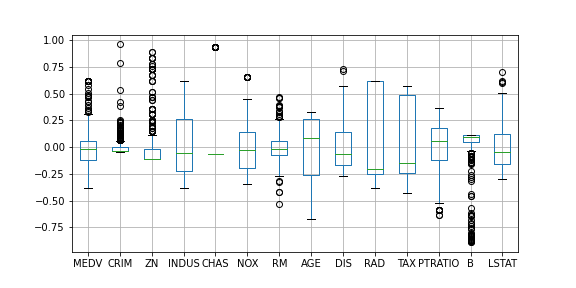


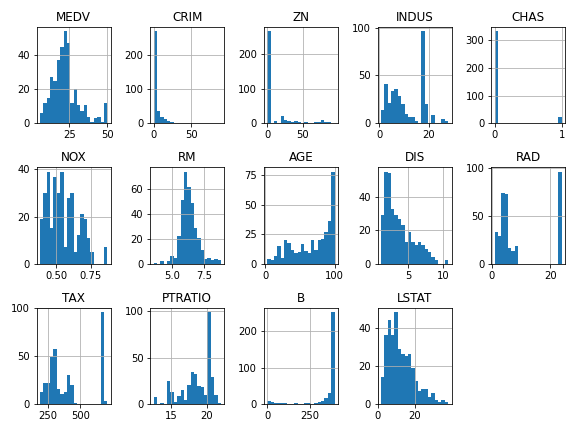

,AGE,CRIM,INDUS,LSTAT,NOX,PTRATIO,RAD,TAX,B,DIS,ZN,CHAS,RM
AGE,1.00,0.35,0.64,0.59,0.74,0.27,0.46,0.51,-0.28,-0.73,-0.56,0.08,-0.21
CRIM,0.35,1.00,0.41,0.43,0.44,0.29,0.62,0.58,-0.41,-0.38,-0.20,-0.06,-0.18
INDUS,0.64,0.41,1.00,0.59,0.78,0.37,0.62,0.72,-0.37,-0.70,-0.52,0.06,-0.36
LSTAT,0.59,0.43,0.59,1.00,0.59,0.39,0.53,0.56,-0.39,-0.47,-0.40,-0.07,-0.60
NOX,0.74,0.44,0.78,0.59,1.00,0.26,0.66,0.71,-0.40,-0.78,-0.53,0.08,-0.26
PTRATIO,0.27,0.29,0.37,0.39,0.26,1.00,0.47,0.45,-0.21,-0.25,-0.37,-0.15,-0.35
RAD,0.46,0.62,0.62,0.53,0.66,0.47,1.00,0.92,-0.48,-0.51,-0.31,-0.02,-0.22
TAX,0.51,0.58,0.72,0.56,0.71,0.45,0.92,1.00,-0.47,-0.53,-0.31,-0.04,-0.29
B,-0.28,-0.41,-0.37,-0.39,-0.40,-0.21,-0.48,-0.47,1.00,0.30,0.18,0.08,0.10
DIS,-0.73,-0.38,-0.70,-0.47,-0.78,-0.25,-0.51,-0.53,0.30,1.00,0.65,-0.10,0.16


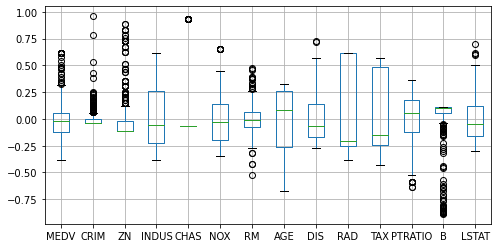

<Figure size 432x288 with 0 Axes>

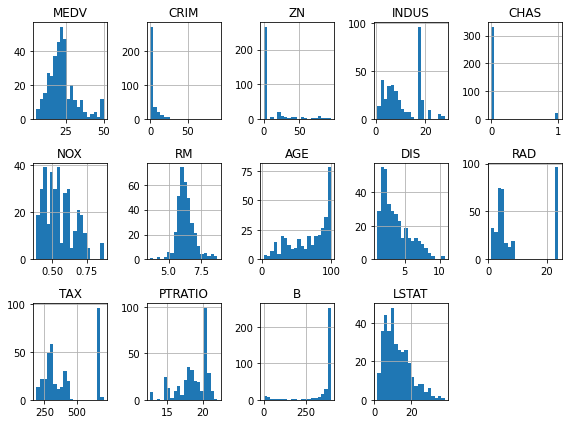

<Figure size 432x288 with 0 Axes>

In [5]:
import scipy.cluster.hierarchy as spc

def plot_corr(df, cluster=False, absolute=False):
    '''
    Prints 
    
    :params df: pd.df
    :params cluster: sorts column if True. bool
    :returns: correlation matrix. pandas.io.formats.style.Styler object
    '''
    corr = df.corr()
    
    if absolute :
        corr = corr.abs()
    
    if cluster :
        pdist = spc.distance.pdist(corr)
        linkage = spc.linkage(pdist, method='complete')
        idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
        new_index = [x for _,x in sorted(zip(idx,list(df.columns)))]
        corr = corr.reindex(new_index)[new_index]
        
        output = corr \
            .style.background_gradient(cmap='coolwarm') \
            .set_precision(2) \
            .set_table_attributes('style="font-size: 10px"')
            #.set_properties(**{'font-size': '0pt'})
    return output

df_all_train = pd.concat([df_targets_train, df_feature_train],axis=1)


pprint('* 데이터 확인')
pprint(((df_all_train-df_all_train.mean()) / (df_all_train.max()-df_all_train.min())).boxplot(figsize=(8,4)), sep='')
df_all_train.hist(bins=20, figsize=(8,6), layout=(3,math.ceil(len(df_all_train.columns)/3)), sharey=False)
plt.tight_layout()
pprint(plt.gcf())
pprint(plot_corr(df_feature_train, cluster=True), save=False)
#df_targets_train.sort_values(ascending=False).head(n=20)
#df_feature_train['NOX'].sort_values(ascending=False).head(n=100).hist(bins=30)
#df_feature_train['PTRATIO'].sort_values(ascending=False).head(n=100).hist(bins=30)
pprint('''target인 MEDV의 최대값(50)의 빈도가 너무 높습니다. clipping되었거나 문제가 있는 값이라고 판단됩니다. 그 외의 feature도 대체로 분포가 skew되어 있지만, 주택 데이터의 특성상 실제 분포가 그럴 수도 있다고 생각됩니다.
Category 데이터인 CHAS feature는 0과 1로 이루어져 있습니다.
RM, LSTAT, AGE, DIS는 대체로 실수형 데이터로 보입니다.
TAX는 multimodal한 데이터입니다. Harrison (1978)에 따르면 town간 과세평가적용률이 무시된 데이터입니다. 두개의 node가 두 가지 과세평가적용률을 의미할 수 있습니다. 만약 그렇다면, 과세평가적용률 데이터가 있다면 조합하여 교차 특성을 만들면 모델이 향상될 가능성이 있습니다.''')
#pprint('''Multimodal : TAX (재산세율)
#숨겨진 변수 때문일 수 있다. Harrison (1978)에 따르면 town간 과세평가적용률이 무시되었다. 만약 그렇다면 과세평가적용률를 반영하는 다른 특성과 조합해 교차 특성을 만들면 효과를 볼 수 있을지도 모른다.''')
#pprint('''Continuous : RM, LSTAT, AGE, DIS (방 개수, 하위계층 비율, 오래된 주택 비율, 통근거리) 주택 품질에 대한 데이터는 대체로 연속적이다. 그러나 RM을 제외하면 대체로 정규분포에서 벗어나 있다.''')


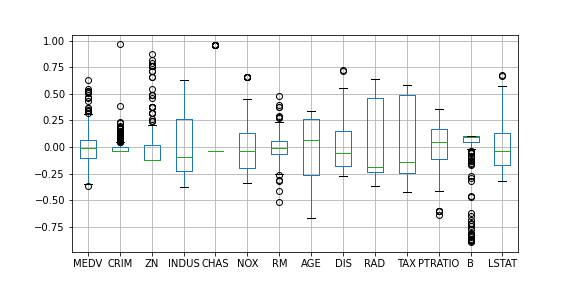


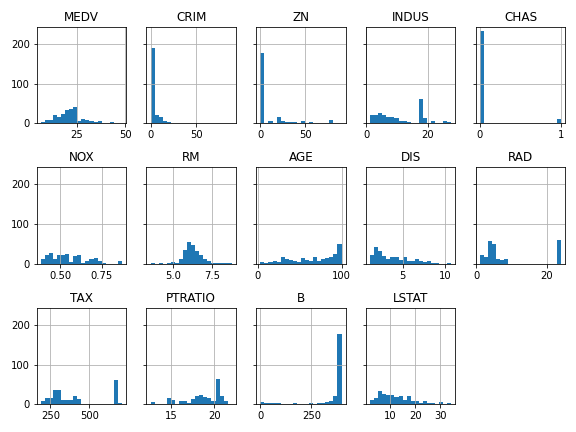

,AGE,CRIM,INDUS,LSTAT,NOX,PTRATIO,RAD,TAX,B,DIS,MEDV,RM,ZN,CHAS
AGE,1.00,0.33,0.63,0.61,0.74,0.24,0.44,0.50,-0.26,-0.72,-0.46,-0.21,-0.54,0.03
CRIM,0.33,1.00,0.39,0.42,0.43,0.27,0.62,0.57,-0.32,-0.38,-0.41,-0.10,-0.20,-0.06
INDUS,0.63,0.39,1.00,0.64,0.76,0.35,0.57,0.67,-0.34,-0.71,-0.55,-0.36,-0.51,0.01
LSTAT,0.61,0.42,0.64,1.00,0.62,0.33,0.53,0.58,-0.41,-0.53,-0.75,-0.54,-0.43,-0.02
NOX,0.74,0.43,0.76,0.62,1.00,0.21,0.63,0.68,-0.38,-0.78,-0.50,-0.26,-0.53,0.02
PTRATIO,0.24,0.27,0.35,0.33,0.21,1.00,0.43,0.40,-0.17,-0.23,-0.49,-0.25,-0.34,-0.13
RAD,0.44,0.62,0.57,0.53,0.63,0.43,1.00,0.90,-0.46,-0.48,-0.48,-0.17,-0.30,-0.06
TAX,0.50,0.57,0.67,0.58,0.68,0.40,0.90,1.00,-0.45,-0.51,-0.57,-0.26,-0.31,-0.09
B,-0.26,-0.32,-0.34,-0.41,-0.38,-0.17,-0.46,-0.45,1.00,0.29,0.38,0.08,0.18,0.06
DIS,-0.72,-0.38,-0.71,-0.53,-0.78,-0.23,-0.48,-0.51,0.29,1.00,0.30,0.16,0.61,-0.06


,AGE,DIS,INDUS,NOX,ZN,CRIM,LSTAT,MEDV,RAD,TAX,B,PTRATIO,RM,CHAS
AGE,1.00,0.72,0.63,0.74,0.54,0.33,0.61,0.46,0.44,0.50,0.26,0.24,0.21,0.03
DIS,0.72,1.00,0.71,0.78,0.61,0.38,0.53,0.30,0.48,0.51,0.29,0.23,0.16,0.06
INDUS,0.63,0.71,1.00,0.76,0.51,0.39,0.64,0.55,0.57,0.67,0.34,0.35,0.36,0.01
NOX,0.74,0.78,0.76,1.00,0.53,0.43,0.62,0.50,0.63,0.68,0.38,0.21,0.26,0.02
ZN,0.54,0.61,0.51,0.53,1.00,0.20,0.43,0.37,0.30,0.31,0.18,0.34,0.27,0.01
CRIM,0.33,0.38,0.39,0.43,0.20,1.00,0.42,0.41,0.62,0.57,0.32,0.27,0.10,0.06
LSTAT,0.61,0.53,0.64,0.62,0.43,0.42,1.00,0.75,0.53,0.58,0.41,0.33,0.54,0.02
MEDV,0.46,0.30,0.55,0.50,0.37,0.41,0.75,1.00,0.48,0.57,0.38,0.49,0.62,0.10
RAD,0.44,0.48,0.57,0.63,0.30,0.62,0.53,0.48,1.00,0.90,0.46,0.43,0.17,0.06
TAX,0.50,0.51,0.67,0.68,0.31,0.57,0.58,0.57,0.90,1.00,0.45,0.40,0.26,0.09



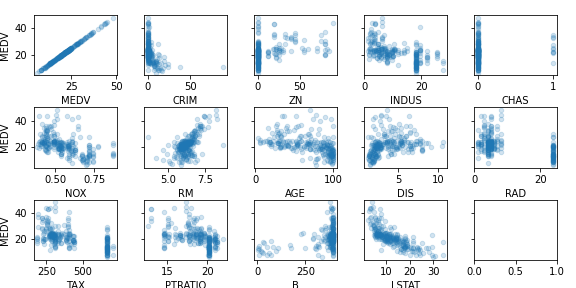

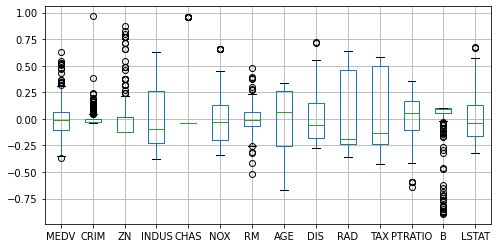

<Figure size 432x288 with 0 Axes>

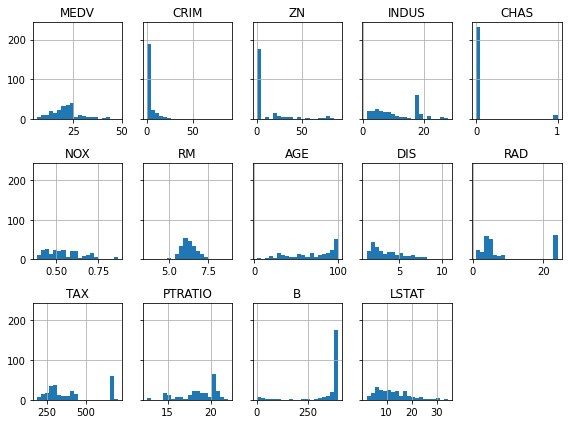

<Figure size 432x288 with 0 Axes>

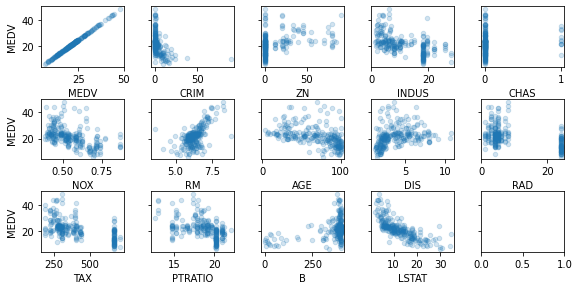

<Figure size 432x288 with 0 Axes>

In [6]:
def preprocess_features(boston_housing_dataframe):
    '''
    Prepare features

    :param df: Raw pd.df containing Boston housing data
    :return: df_feature_train, df_feature_test, df_feature_validate, df_targets_train, df_targets_test, df_targets_validate
    '''
    feature = boston_housing_dataframe.copy()

    df_feature_train, df_feature_test, df_feature_validate = cut_data(feature,[0.5,0.25])
    
    df_feature_train = df_feature_train[df_feature_train.MEDV!=df_feature_train.MEDV.max()]
    #df_feature_train = df_feature_train[df_feature_train.NOX !=df_feature_train.NOX.max() ]
    #df_feature_train['NOX'] = np.power(df_feature_train['NOX'],2) # Belsley (1980)
    #df_feature_train['RM' ] = np.power(df_feature_train['RM' ],2) # Harrison (1978)
    
    df_feature_test  = df_feature_test [df_feature_test .MEDV!=df_feature_test .MEDV.max()]
    #df_feature_test  = df_feature_test [df_feature_test .NOX !=df_feature_test .NOX.max() ]
    #df_feature_test ['NOX'] = np.power(df_feature_test ['NOX'],2) # Belsley (1980)
    #df_feature_train['RM' ] = np.power(df_feature_train['RM' ],2) # Harrison (1978)

    global allow_validation_set_modification
    if allow_validation_set_modification:
        df_feature_validate  = df_feature_validate [df_feature_validate .MEDV!=df_feature_validate .MEDV.max()]

    target = 'MEDV'
    df_targets_train = pd.DataFrame(df_feature_train.pop('MEDV'))
    df_targets_test = pd.DataFrame(df_feature_test.pop('MEDV'))
    df_targets_validate = pd.DataFrame(df_feature_validate.pop('MEDV'))
    return df_feature_train, df_feature_test, df_feature_validate, df_targets_train, df_targets_test, df_targets_validate


df_feature_train, df_feature_test, df_feature_validate, df_targets_train, df_targets_test, df_targets_validate \
= preprocess_features(df_boston_housing)

pprint('* 데이터 상관관계 확인')
if allow_validation_set_modification:
    pprint('MEDV의 이상치를 제거하고 분석하였습니다.', sep='')
else:
    pprint('validation set을 제외한 train, test set에서 MEDV의 이상치를 제거하고 분석하였습니다.', sep='')

df_all_train = pd.concat([df_targets_train, df_feature_train],axis=1)
pprint(((df_all_train-df_all_train.mean()) / (df_all_train.max()-df_all_train.min())).boxplot(figsize=(8,4)), save=False)
df_all_train.hist(bins=20, figsize=(8,6), layout=(3,math.ceil(len(df_all_train.columns)/3)), sharey=True)
plt.tight_layout()
pprint(plt.gcf(), save=False)
pprint('Correlation matrix(signed, unsigned), hierarchical clustering')
pprint(plot_corr(df_all_train, cluster=True), sep='')
pprint(plot_corr(df_all_train, cluster=True, absolute=True), sep='')
pprint('''MEDV와 양의 상관관계를 갖는 데이터와 음의 상관관계를 갖는 데이터가 구분됩니다.
MEDV와 음의 상관관계를 가지는 feature가 8개, 양의 상관관계를 가지는 feature가 4개, 상관관계가 없는 feature가 1개 있습니다.''')
pprint('''유사한 데이터셋이 관찰됩니다. correlation이 0.7 이상인 (AGE,DIS,NOX,INDUS), (LSTAT,MEDV), (RAD,TAX) 는 거의 동일한 데이터입니다.
더미 데이터가 관찰됩니다. MEDV와의 상관관계가 0.2 이하인 CHAS는 더미 데이터입니다.''', sep='')

fig, ax = plt.subplots(3, math.ceil(len(df_all_train.columns)/3), figsize=(8,4), sharey=True)
fig.tight_layout()
ax_flat = ax.flatten()
for i in range(df_all_train.shape[1]):
    df_all_train.plot.scatter(df_all_train.columns[i], 'MEDV', ax=ax_flat[i], alpha=0.2)
pprint(fig)   

pprint('''RM, LSTAT이 MDEV과 강한 상관관계가 있음을 확인할 수 있습니다.
DIS의 경우 MDEV<20 구간에서만 잘 예측하는 특징이 있습니다.''')


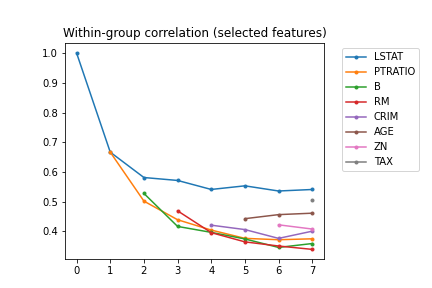


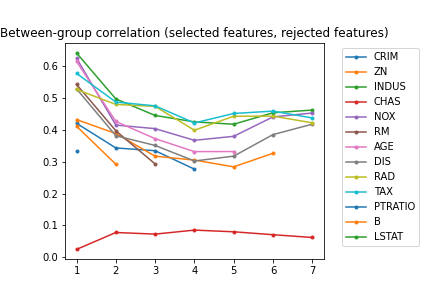

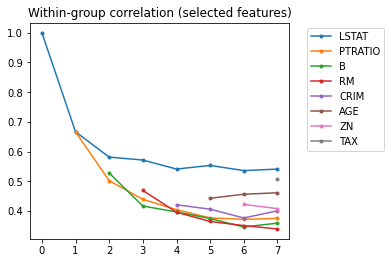

<Figure size 432x288 with 0 Axes>

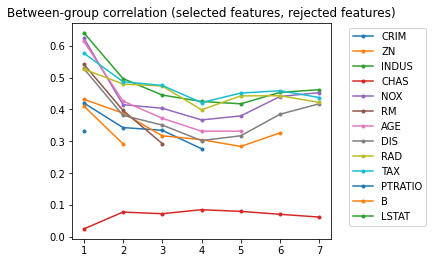

<Figure size 432x288 with 0 Axes>

In [7]:
def greedy_feature_selection(df, target_name, dummy_name):
    #corr_all = df.copy().rank().corr().abs()
    corr_all = df.copy().corr().abs()
    
    target = df[target_name]
    selected_feature = []
    #selected_feature = ['LSTAT','RM','PTRATIO','NOX']
    rejected_feature = [x for x in df.columns if ((x is not target_name) and (x not in selected_feature))]
    
    def thres_score(too_bad, good_enough):
        return (
            lambda x : np.interp(x, [-1000, too_bad, good_enough, 10000], [-10000,0,good_enough,1000]) if np.isfinite(x) else 0
        )   
    
    within_group_corr = []
    between_group_corr = []
    avg_target_corr = []
    while (len(rejected_feature)>0) :
        prediction_power = corr_all.loc()['MEDV'][rejected_feature].map( thres_score(0.0,0.6) )
        correlation = corr_all.loc()[rejected_feature][selected_feature]
        uniqueness = correlation.apply(lambda x : 1.0-x.mean(),axis=1).map( thres_score(1.0-0.6,1.0-0.3) )
        score = prediction_power+uniqueness
        winner = score.idxmax()
        if (winner == dummy_name and len(selected_feature)>5) :
            break
        #print(f'Adding {winner}\tScore: {score[winner]:.2f} vs {score[dummy_name]:.2f}')
        rejected_feature.remove(winner)
        if (winner != dummy_name): selected_feature.append(winner)
        self_correlation = corr_all.loc()[selected_feature][selected_feature].mean(axis=1)
        within_group_corr+=[self_correlation.copy()]
        between_group_corr+=[correlation.mean(axis=1).copy()]
        avg_target_corr.append(corr_all.loc()['MEDV'][selected_feature].mean())
        #stat.append(prediction_power[selected_feature].mean()*len(selected_feature))
    
    ax = plt.figure().add_axes([0.15, 0.1, 0.6, 0.75])
    p = pd.concat(within_group_corr,axis=1).T.plot(style='.-', ax=ax, title='Within-group correlation (selected features)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    pprint(p, sep='')
    ax = plt.figure().add_axes([0.15, 0.1, 0.6, 0.75])
    p = pd.concat(between_group_corr,axis=1).T.plot(style='.-', ax=ax, title='Between-group correlation (selected features, rejected features)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    pprint(p, sep='')
    
    pprint(f'selected_features: {selected_feature}\nrejected_features : {rejected_feature}')
    #pd.Series(avg_target_corr).plot()
    return selected_feature

pprint('* Feature 선택')
selected_feature = greedy_feature_selection(df_all_train,'MEDV','CHAS')


In [8]:
pprint('''Within-group correlation : 선택한 feature set의 intrinsic dimension이 증가함을 의미합니다. (intrinsic dimension : F Camastra 2002)
Between-group correlation : 데이터를 5개 선택하면 나머지 feature를 예측하기 시작함을 의미합니다.''', sep='')

pprint(f'''Correlation을 기준으로 예측력이 높으면서 중복되지 않는 데이터를 greedy하게 선택하여, dummy가 나올때까지 반복했습니다.
위의 차트로부터 적절한 feature의 개수는 5개~8개 정도로 예상됩니다. {len(selected_feature)}개 사용하기로 하였습니다.''', sep='')


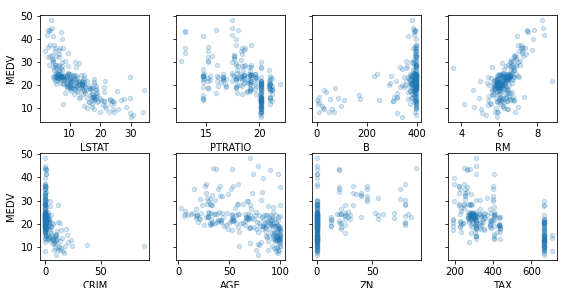

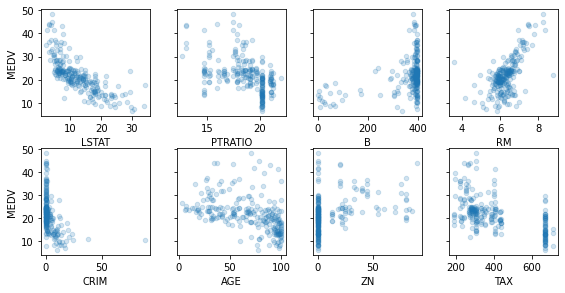

<Figure size 432x288 with 0 Axes>

In [9]:
# for i in range(df_all_train.shape[1]):
#     df_all_train.plot.scatter(df_all_train.columns[i], 'MEDV', ax=ax_flat[i], alpha=0.2)
fig, ax = plt.subplots(2, math.ceil(len(selected_feature)/2), figsize=(8,4), sharey=True)
fig.tight_layout()
ax_flat = ax.flatten()
for i in range(df_all_train[selected_feature].shape[1]):
    df_all_train.plot.scatter(df_all_train[selected_feature].columns[i], 'MEDV', ax=ax_flat[i], alpha=0.2)
    
pprint('선택된 feature에 대한 Scatter Plot')
pprint(fig, sep='')

data_types = {'bucket': ['B', 'CRIM', 'ZN', 'TAX', 'RAD'],
'numeric': ['LSTAT', 'PTRATIO', 'RM', 'MEDV', 'INDUS', 'NOX', 'AGE', 'DIS'],
'categorical': ['CHAS']}
#pprint('데이터를 보고, 다음과 같이 구분하였습니다.\n' + str(data_types))

/Users/jongkook90/Library/Caches/pypoetry/virtualenvs/kakao-interview-qbcGGNGB-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1666.9075650201405, tolerance: 2.4085326505102045
  model = cd_fast.enet_coordinate_descent(
/Users/jongkook90/Library/Caches/pypoetry/virtualenvs/kakao-interview-qbcGGNGB-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1682.0384599113722, tolerance: 2.4778221198979593
  model = cd_fast.enet_coordinate_descent(
/Users/jongkook90/Library/Caches/pypoetry/virtualenvs/kakao-interview-qbcGGNGB-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.


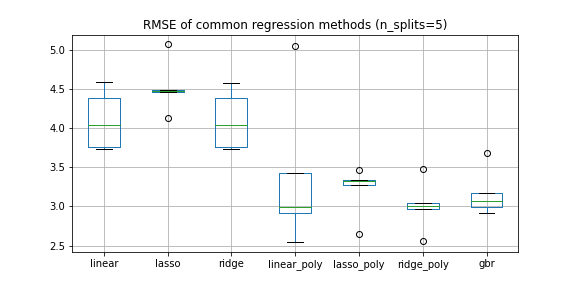

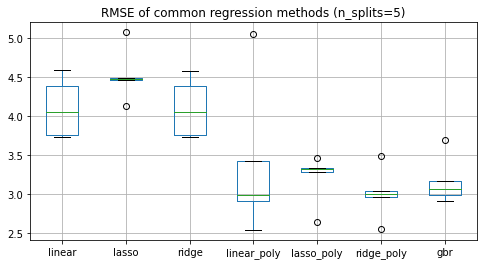

<Figure size 432x288 with 0 Axes>

In [10]:
from sklearn import linear_model
l_regression = linear_model.LinearRegression()
l_lasso = linear_model.Lasso()
l_ridge = linear_model.Ridge()

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
p_regression = make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression())
p_lasso = make_pipeline(PolynomialFeatures(degree=2), linear_model.Lasso())
p_ridge = make_pipeline(PolynomialFeatures(degree=2), linear_model.Ridge())

from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

models = {'linear':l_regression, 'lasso':l_lasso, 'ridge':l_ridge,
         'linear_poly':p_regression, 'lasso_poly':p_lasso, 'ridge_poly':p_ridge, 'gbr':gbr}

#scores_list={
#    k:cross_val_score(v, df_feature_train[selected_feature], df_targets_train['MEDV'], cv=kf, scoring='neg_root_mean_squared_error')
#    for k,v in models.items()}

if allow_validation_set_modification:
    df_boston_housing = df_boston_housing[df_boston_housing.MEDV != df_boston_housing.MEDV.max()]

scores_list={
    k:cross_val_score(v, df_boston_housing[selected_feature], df_boston_housing['MEDV'], cv=kf, scoring='neg_root_mean_squared_error')
    for k,v in models.items()}


plt.figure(figsize=(8, 4))
pprint('일반적인 regression method 적용')
plt.title('RMSE of common regression methods (n_splits=5)')
pprint(pd.concat([-pd.Series(v,name=k) for k,v in scores_list.items()],axis=1).boxplot(), sep='')
pprint('''linear, polynomial model에 대하여 여러 가지 regression method를 적용하였습니다.
전반적으로 Polynomial model이 Linear model에 비해 더 좋은 성능을 보입니다.
ensemble method인 gbr을 적용해도 큰 차이가 없는 것으로 보아, feature의 nonlinearity가 주로 2차 정도라고 판단됩니다''', sep='')

In [11]:
## Reference : https://www.tensorflow.org/tutorials
## https://www.tensorflow.org/guide/keras/functional

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
tf.keras.backend.set_floatx('float32')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

def deep_learning(
    df_feature_train,df_targets_train,
    df_feature_test,df_targets_test,
    df_feature_validate,df_targets_validate,
    batch_size=32, epochs=20, max_price=50
):
    # 판다스 데이터프레임으로부터 tf.data 데이터셋을 만들기 위한 함수
    def df_to_dataset(df_feature, df_targets, shuffle=True, batch_size=32):
        df_feature = df_feature.copy()
        df_targets = df_targets.copy()
        #ds = tf.data.Dataset.from_tensor_slices((df_feature.to_dict(orient='list'), df_targets))
        ds = tf.data.Dataset.from_tensor_slices((dict(df_feature), df_targets))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(df_feature))
        ds = ds.batch(batch_size)
        return ds

    # 입력 파이프라인 만들기
    #batch_size = 32
    scaler = preprocessing.StandardScaler()
    df_feature_train_scaled = pd.DataFrame(scaler.fit_transform(df_feature_train), columns = df_feature_train.columns)
    df_feature_test_scaled = pd.DataFrame(scaler.fit_transform(df_feature_test), columns = df_feature_test.columns)
    df_feature_validate_scaled = pd.DataFrame(scaler.fit_transform(df_feature_validate), columns = df_feature_test.columns)

    #max_price = 50
    train_ds = df_to_dataset(df_feature_train_scaled[selected_feature],df_targets_train.MEDV/max_price, shuffle=False, batch_size=batch_size)
    test_ds = df_to_dataset(df_feature_test_scaled[selected_feature],df_targets_test.MEDV/max_price, shuffle=False, batch_size=batch_size)
    val_ds = df_to_dataset(df_feature_validate_scaled[selected_feature],df_targets_validate.MEDV/max_price, shuffle=False, batch_size=batch_size)

    feature_columns = []
    feature_layer_inputs = {}

    # 수치형 열
    for header in [x for x in selected_feature]:
        feature_columns.append(feature_column.numeric_column(header, dtype=tf.float64))
        feature_layer_inputs[header] = tf.keras.Input(shape=(1,), name=header)

    raw_features_idx = {x[1].key:x[0] for x in enumerate(feature_columns)}

    # 버킷형 열
    # quantiles = df_feature_train.quantile(q=[0.2,0.4,0.6,0.8], interpolation='nearest')
    # for header in [x for x in selected_feature if (x in data_types['bucket'])]:
    #     bucktized_feature = feature_column.bucketized_column(
    #         #feature_columns[raw_features_idx[header]],
    #         feature_column.numeric_column(header, dtype=tf.float64),
    #         boundaries = quantiles[header].unique().tolist())
    #     feature_columns.append(bucktized_feature)
    #     # self cross (안됨)
    #     feature_layer_inputs['bucket_'+header] = tf.keras.Input(shape=(1,), name='bucket_'+header)
    #     self_cross_feature = feature_column.indicator_column(feature_column.crossed_column(
    #         ['bucket_'+header,header], hash_bucket_size=1000))
    #     feature_columns.append(self_cross_feature)

    # 범주형 (CHAS밖에 없으므로 보통은 실행되지 않음)
    # for header in [x for x in selected_feature if (x in data_types['categorical'])]:
    #     feature_columns.append(feature_column.categorical_column_with_identity(header))
    #     feature_layer_inputs[header] = tf.keras.Input(shape=(1,), name=header)

    # 교차 특성 열
    def add_crossed_feature(feature_columns, headers):
        if len(headers) > 1 :
            feature_columns.append(feature_column.indicator_column(feature_column.crossed_column(
                    headers, hash_bucket_size=1000)))  
    # 유사한 특성별로 교차 특성 추가
    #add_crossed_feature(feature_columns, [x for x in selected_feature if (x in data_category['neighborhood'])])
    #add_crossed_feature(feature_columns, [x for x in selected_feature if (x in data_category['structural'])])
    #add_crossed_feature(feature_columns, [x for x in selected_feature if (x in data_category['accessibility']+data_category['pollution'])])
    #add_crossed_feature(feature_columns, ['TAX','B'])

    # 특성 층 만들기
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

    # 모델 생성, 컴파일, 훈련

    tf.random.set_seed(0)
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
    feature_layer_outputs = feature_layer(feature_layer_inputs)
    x = layers.Dense(128, activation='relu')(feature_layer_outputs)
    x = layers.Dense(128, activation='relu')(x)
    baggage_pred = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[v for v in feature_layer_inputs.values()], outputs=baggage_pred)


    model.compile(optimizer='adam',
                  loss='mae',
                  metrics=['mse'])

    history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=epochs)

    history.history['mse'] = [x*max_price*max_price for x in history.history['mse']]
    history.history['val_mse'] = [x*max_price*max_price for x in history.history['val_mse']]
    history.history['loss'] = [x*max_price for x in history.history['loss']]
    history.history['val_loss'] = [x*max_price for x in history.history['val_loss']]
    return model, history, val_ds

Epoch 1/25
4/4 [==============================] - 0s 40ms/step - loss: 0.1203 - mse: 0.0245 - val_loss: 0.0901 - val_mse: 0.0138
Epoch 2/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0723 - mse: 0.0100 - val_loss: 0.0658 - val_mse: 0.0079
Epoch 3/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0647 - mse: 0.0080 - val_loss: 0.0603 - val_mse: 0.0069
Epoch 4/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0610 - mse: 0.0071 - val_loss: 0.0515 - val_mse: 0.0051
Epoch 5/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0511 - mse: 0.0053 - val_loss: 0.0478 - val_mse: 0.0041
Epoch 6/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0490 - mse: 0.0045 - val_loss: 0.0492 - val_mse: 0.0043
Epoch 7/25
4/4 [==============================] - 0s 3ms/step - loss: 0.0474 - mse: 0.0042 - val_loss: 0.0470 - val_mse: 0.0039
Epoch 8/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0439 - mse: 0.0038 - val_loss: 


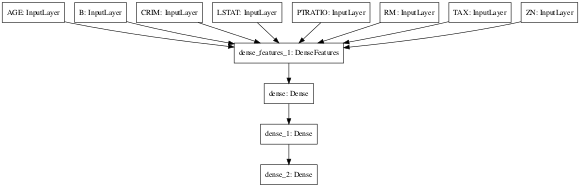

In [12]:
max_price=50
model, history, val_ds = deep_learning(
    df_feature_train,df_targets_train,
    df_feature_test,df_targets_test,
    df_feature_validate,df_targets_validate,
    batch_size=64, epochs=25, max_price=max_price
)
pprint('* Deep learning')
pprint('tensorflow.org/tutorials을 참고하여 128 크기의 hidden layer 2개를 이용한 deep learning 모델을 다음과 같이 작성 후 train 하였습니다.')
pprint(tf.keras.utils.plot_model(model, show_shapes=False, dpi=40))

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])



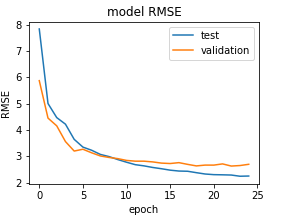


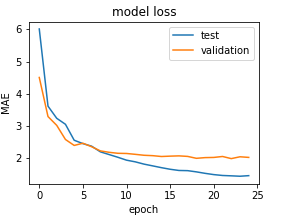

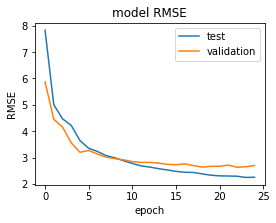

<Figure size 432x288 with 0 Axes>

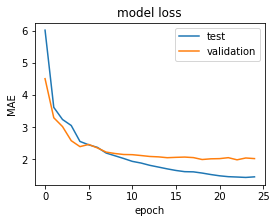

<Figure size 432x288 with 0 Axes>

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
ax = plt.figure(figsize=(4,3)).add_axes([0.1, 0.15, 0.8, 0.75])
plt.plot(np.sqrt(history.history['mse']))
plt.plot(np.sqrt(history.history['val_mse']))
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['test', 'validation'], loc='upper right')
#plt.show()
pprint(plt.gcf())
# summarize history for loss
ax = plt.figure(figsize=(4,3)).add_axes([0.1, 0.15, 0.8, 0.75])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['test', 'validation'], loc='upper right')
#plt.show()
pprint(plt.gcf(),sep='')
pprint("""Outlier가 있을 수 있다고 생각해 MAE를 loss function으로 잡고 25 epoch training 하였습니다.
Second order polinomial fitting과 유사한 결과를 얻었습니다.
더 많은 데이터를 얻거나, feature간의 관계를 좀더 잘 파악하면 결과를 개선할 수 있을 것입니다.""")


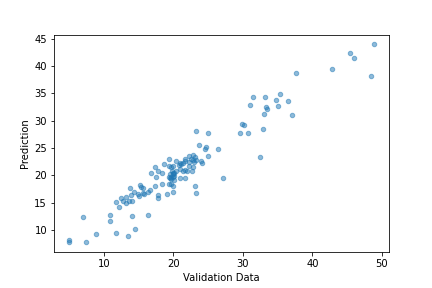

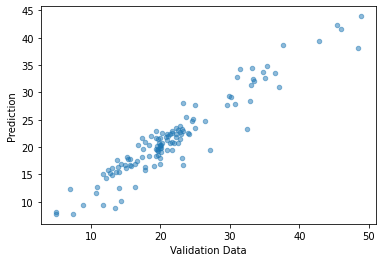

<Figure size 432x288 with 0 Axes>

In [14]:
pprint(
    pd.concat([
    pd.Series(df_targets_validate.values.T.flatten(),name='Validation Data'),
    pd.Series((model.predict(val_ds).T*50).flatten(),name='Prediction')
],axis=1).plot.scatter(0,1, alpha=0.5), sep=''
)

if not allow_validation_set_modification:
    pprint('''오차가 상당 부분(RMSE 2 정도) Validation data에서 MEDV=50($50000) 인 경우에 발생하는 것을 관찰할 수 있습니다.
    training 및 test set에서만 이러한 outlier를 제거하였기 때문에 실제로는 오차가 더 적을 수 있습니다.''', sep='')
pprint('Validation set을 이용한 model의 prediction이 실제 값과 잘 일치하는 것이 확인됩니다.', sep='')


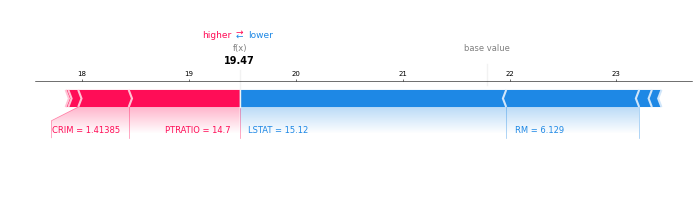


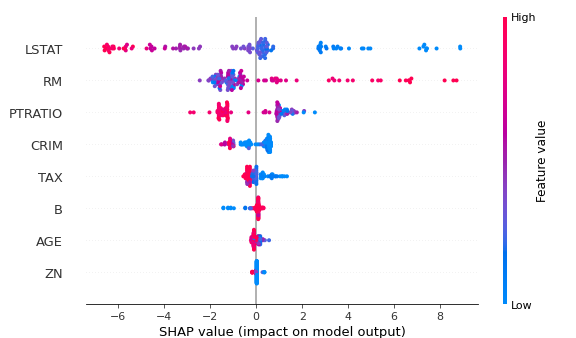

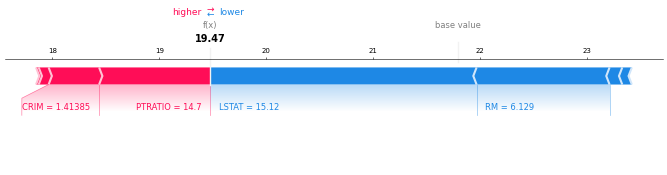

<Figure size 432x288 with 0 Axes>

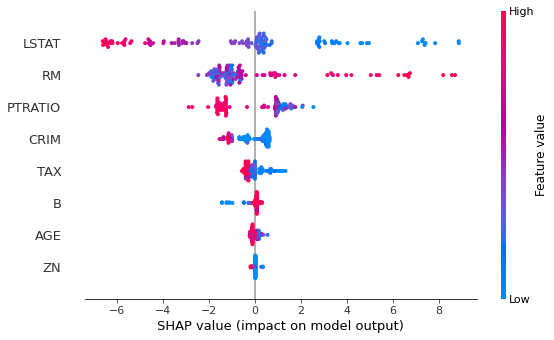

<Figure size 432x288 with 0 Axes>

In [15]:
pprint('* 모델 설명')
pprint('Feature 중요도 파악 등을 위해, GBR 모델의 피팅 결과를 feature별로 관찰하겠습니다.', sep='')
from sklearn.model_selection import train_test_split
import shap

train_X, val_X, train_y, val_y = df_feature_train[selected_feature], df_feature_test[selected_feature], df_targets_train['MEDV'], df_targets_test['MEDV']
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)
model = gbr.fit(train_X, train_y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_X)
i=20
pprint(f'임의의({val_X.iloc[i].name}번째) 데이터의 SHAP (각 feature가 준 영향, model이 보는 feature의 중요도.)')
#fig = plt.figure()
#fig.add_axes([0.15, 0.1, 0.85, 0.85])
shap.force_plot(explainer.expected_value[0], shap_values[i], val_X.iloc[i], matplotlib=True, show=False)
a = plt.gca()
a.figure.set_size_inches(14,4)
a.figure.set_dpi(50)
#a.figure.add_artist()
plt.tight_layout()
pprint(plt.gca(),sep='')

pprint(f'SHAP summary plot. model은 일부 데이터에 대해 LSTAT에 많이 의존하여 가격을 결정하였습니다.')
fig = plt.figure()
fig.add_axes([0.15, 0.1, 0.85, 0.85])
shap.summary_plot(shap_values, val_X, show=False)
pprint(plt.gca(),sep='')


The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


Weight,Feature
0.5131 ± 0.1792,LSTAT
0.2295 ± 0.0366,RM
0.0711 ± 0.0196,PTRATIO
0.0160 ± 0.0106,CRIM
0.0155 ± 0.0118,TAX
0.0056 ± 0.0084,B
0.0036 ± 0.0045,AGE
0.0005 ± 0.0013,ZN



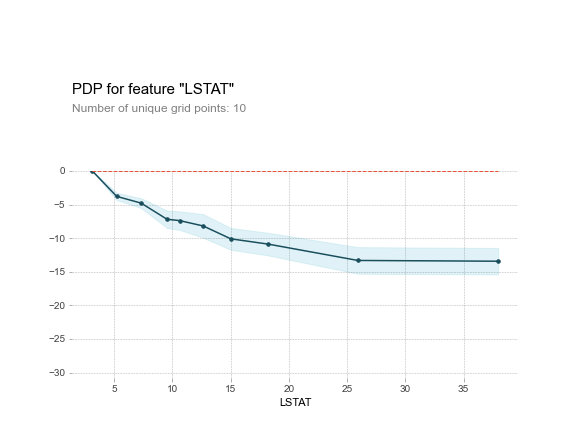

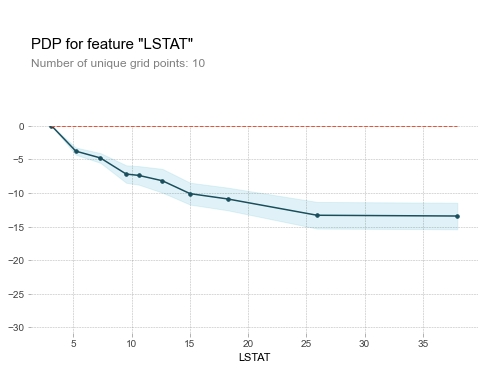

<Figure size 432x288 with 0 Axes>

In [16]:
import eli5
from eli5.sklearn import PermutationImportance

pprint('Permutation plot과 Partial plot')
perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)
a = eli5.show_weights(perm, feature_names = val_X.columns.tolist())
pprint(a)

import pdpbox
from pdpbox import pdp
output = pdp.pdp_isolate(model, val_X, val_X.columns, 'LSTAT')
fig = pdp.pdp_plot(output, 'LSTAT', figsize=(8,6))
pprint(fig[0], sep='')

pprint('LSTAT은 일관된 partial plot을 보여주면서 높은 permutation을 보여주므로, overfitting이 아니라 실제로 중요한 feature임을 알 수 있습니다.', sep='')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.23,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00
,AGE,CRIM,INDUS,LSTAT,NOX,PTRATIO,RAD,TAX,B,DIS,MEDV,RM,ZN,CHAS
AGE,1.00,0.33,0.63,0.61,0.74,0.24,0.44,0.50,-0.26,-0.72,-0.46,-0.21,-0.54,0.03

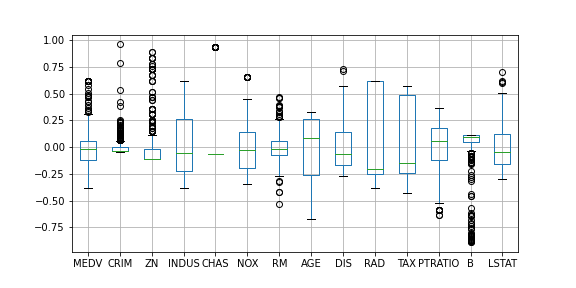
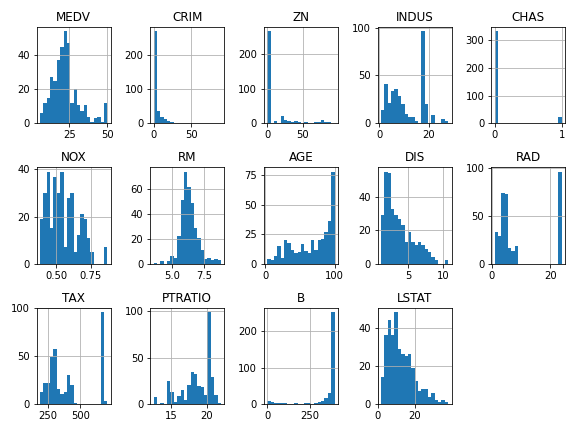
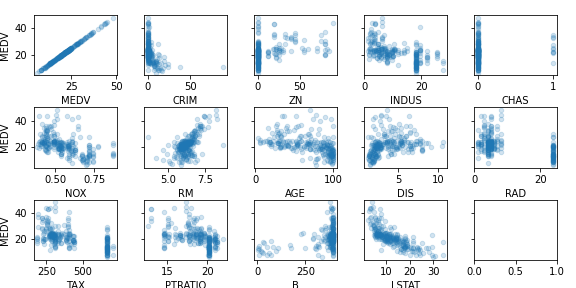
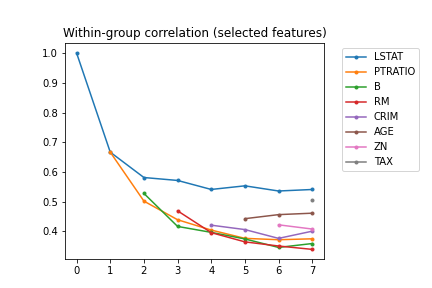
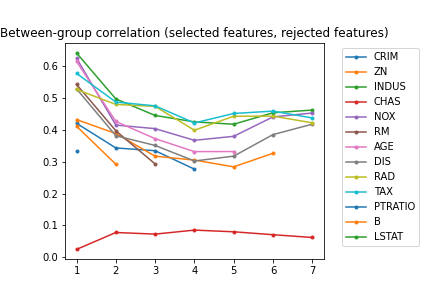
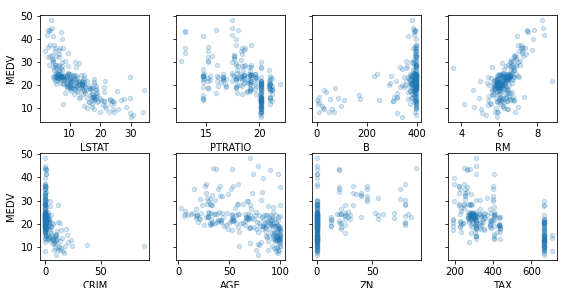
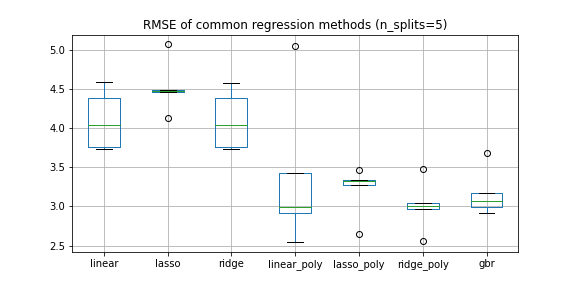
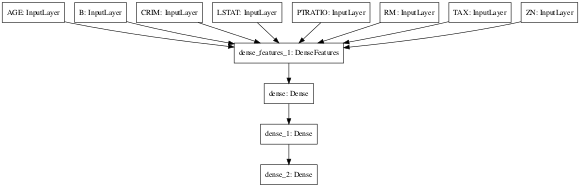
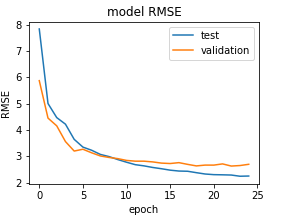
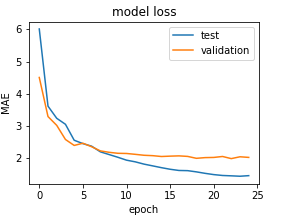
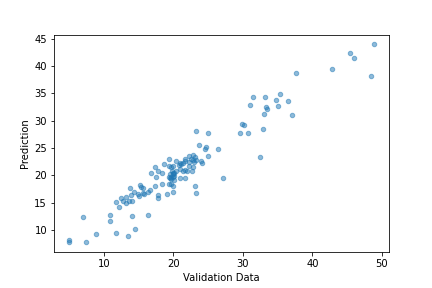
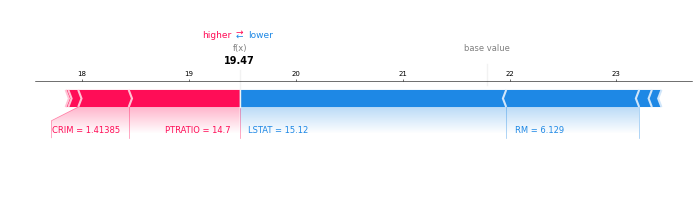
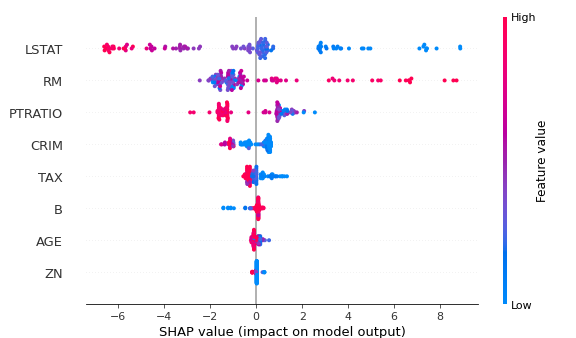
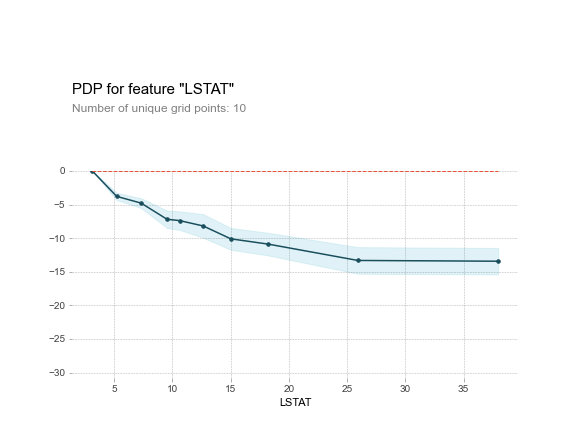

In [24]:
display(HTML(html_output))

title_text = '보스턴 주택 가격 Report'
summary_text = '''Second order polynomial regression 및 gradient boosting regression을 통해 데이터를 피팅하여 RMSE=6% 정도의 모델을 얻었습니다. 
SHAP을 통해 모델을 분석한 결과, 하위계층 비율(LSTAT)이 음의 방향으로, 방 개수(+RM)가 양의 방향으로 각각 주택 가격 예측에 가장 큰 영향을 주었으며, 특히 방 개수는 많을 때 model에 impact가 큰 것을 확인하였습니다.
Model 생성을 위한 feature selection은 correlation에 기반한 score를 이용하여 greedy하게 선택하였습니다.
추가적으로, deep learning 모델과의 비교를 수행하였습니다.'''

output_path = './result/'
html_path = output_path+'report.html'
pdf_path = output_path+'report.pdf'
header = '''<meta http-equiv="Content-Type" content="text/html; charset=utf-8">
<html>
<head>
<link rel="preconnect" href="https://fonts.gstatic.com"> 
<link href="https://fonts.googleapis.com/css2?family=Noto+Sans+KR&display=swap" rel="stylesheet">
<style>
body {
font-family: "Noto Sans KR", sans-serif;
column-count: 2;
column-gap: 32px;
column-rule-style : solid; colmn-rule-width : 3px; column-rule-color: #ccc;
}
</style>
</head>
<body>
<h1 style="column-span:all;">'''+title_text+'''</h1>
<p style="column-span:all; text-align: right">Jongkook Choi<br/>jongkook90@gmail.com</p>
<p style="column-span:all;">'''+summary_text+'''</p>
'''
footer = '''
</html>
'''

with open(html_path, 'w') as html_file:
    html_file.write(header+html_output+footer)